In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime, timedelta
import random
from cartopy import crs as ccrs, feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import xarray as xr
from netCDF4 import Dataset
from scipy.interpolate import griddata
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import os


In [2]:
YES = 1
NO = 0

In [3]:
import math as m

def get_distance(lat1, lat2, lon1, lon2, R):
    """Calculate distance between start and end points using Harvesin formula
    Result in meters (m)!"""
    # Convert lat and lon to radians for the formula
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    a = np.power(np.sin((lat2-lat1) / 2), 2) + np.cos(lat1) * np.cos(lat2) * np.power(np.sin((lon2-lon1) / 2), 2)
    distance = 2 * R * np.arcsin(np.sqrt(a))
    return distance * 1000

def get_angle(point1, point2):
    """ Get angle (in radians) of segment of line with respect to x-axis"""
    y2 = point2[1]
    x2 = point2[0]
    y1 = point1[1]
    x1 = point1[0]

    if x1 == x2:
        theta = m.pi/2 if y2 > y1 else -m.pi/2  # 0 degrees for North, -180 for South
    else:
        slope = (y2-y1)/(x2-x1)
        theta = np.arctan(slope)

    return theta

def get_velocity (u, v, theta):
    """ Compute the velocity based on u (x-axis) and v (y-axis) velocities and the angle theta (relative to x-axis)"""
    return u*np.sin(theta) + v*np.cos(theta)



def find_angle_variations(lats, lons, a):
    """Computes the angle between two consecutive stations and detects angles above a degrees.
       Stores the coordinates where these variations are detected. """
    
    thetas = []
    borders_idx = []
    borders_idx.append(0)

    if len(lats) != len(lons):
        print("Lats and lons should have same dimensions.")
        return None, None
    
    for i in range(len(lats) - 1):
        lat1, lon1 = lats[i], lons[i]
        lat2, lon2 = lats[i + 1], lons[i + 1]
        
        angle = get_angle([lon1, lat1], [lon2, lat2])
            
        if len(thetas) > 0 and abs(angle - thetas[-1]) > np.radians(a):
            borders_idx.append(i)

        thetas.append(angle)

    borders_idx = [borders_idx[0]] + [borders_idx[j] for j in range(1, len(borders_idx)) if (borders_idx[j] - borders_idx[j-1]) > 2]
    borders_idx.append(i+1)

    return thetas, borders_idx



In [4]:
a = get_angle([0,0], [1,1])
np.degrees(a)

np.float64(45.0)

In [5]:
class Transect:
    def __init__(self, lat1, lat2, lon1, lon2, i, month, year) -> None:

        self.label = i
        self.month = month
        self.year = year
        self.theta = get_angle([lon1,lat1], [lon2,lat2])
        self.distance = get_distance(lat1, lat2, lon1, lon2, 6371)
        self.lat1 = lat1
        self.lat2 = lat2
        self.lon1 = lon1
        self.lon2 = lon2
        self.lats = []
        self.lons = []
        self.depths = []
        self.distances = []

        self.velocities = []
        self.data_points = []
        self.grid_points = []

class TransectInfo:
    def __init__(self, lat1, lat2, lon1, lon2, i, params) -> None:

        self.label = i
        self.theta = get_angle([lon1,lat1], [lon2,lat2])
        self.distance = get_distance(lat1, lat2, lon1, lon2, 6371)
        self.lat1 = lat1
        self.lat2 = lat2
        self.lon1 = lon1
        self.lon2 = lon2
        self.lats = []
        self.lons = []
        self.depths = []
        self.distances = []

        self.grid_points = []
        self.params = params
        
        self.num_cells_x = int(np.ceil(self.distance / self.params['delta_distance'])) if self.params['delta_distance'] < self.distance else 1
        self.num_cells_z = int(np.ceil((self.params['max_depth'] - self.params['min_depth']) / self.params['delta_depth'])) if self.params['delta_depth'] < self.params['max_depth'] else 1

    def print_info(self):
        
        print(f"Transect no.{self.label}")
        print(f"Angle theta = {np.degrees(self.theta)}")
        print(f"Total distance d = {self.distance} m")
    
        print(f"Initial coordinates: ({self.lat1}, {self.lon1})")
        print(f"Final coordinates: ({self.lat2}, {self.lon2})")


class Box:
    def __init__(self, lat1, lat2, lon1, lon2, params) -> None:
        self.lat1 = lat1
        self.lat2 = lat2
        self.lon1 = lon1
        self.lon2 = lon2
        self.vdistance = get_distance(lat1, lat2, lon1, lon1, R=6371)
        self.hdistance = get_distance(lat1, lat1, lon1, lon2, R=6371) 
        self.num_cells_lat = 5
        self.num_cells_lon = 10
        self.num_cells_dep = 10
        self.lats = np.linspace(lat1, lat2, self.num_cells_lat + 1)
        self.lons = np.linspace(lon1, lon2, self.num_cells_lon + 1)
        self.depths = np.linspace(params['min_depth'], params['max_depth'], self.num_cells_dep + 1)
        self.grid = []
        self.info_transects = []



### Data

In [6]:
file_path = 'data/HD_Monthly_Data_19932020.nc'
data = xr.open_dataset(file_path)
data

<xarray.Dataset> Size: 53GB
Dimensions:    (depth: 40, latitude: 265, longitude: 457, time: 336)
Coordinates:
  * depth      (depth) float32 160B 0.494 1.541 2.646 ... 1.684e+03 1.942e+03
  * latitude   (latitude) float32 1kB 44.0 44.08 44.17 ... 65.83 65.92 66.0
  * longitude  (longitude) float32 2kB -30.0 -29.92 -29.83 ... 7.833 7.917 8.0
  * time       (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2020-12-01
Data variables:
    so         (time, depth, latitude, longitude) float64 13GB ...
    thetao     (time, depth, latitude, longitude) float64 13GB ...
    bottomT    (time, latitude, longitude) float64 326MB ...
    uo         (time, depth, latitude, longitude) float64 13GB ...
    vo         (time, depth, latitude, longitude) float64 13GB ...
    mlotst     (time, latitude, longitude) float64 326MB ...
    zos        (time, latitude, longitude) float64 326MB ...
Attributes: (12/15)
    Conventions:                       CF-1.6
    area:                              GLOBAL
    contact:                           servicedesk.cmems@mercator-ocean.eu
    credit:                            E.U. Copernicus Marine Service Informa...
    dataset:                           global-reanalysis-001-030-monthly
    institution:                       Mercator Ocean
    ...                                ...
    product_user_manual:               http://marine.copernicus.eu/documents/...
    quality_information_document:      http://marine.copernicus.eu/documents/...
    references:                        http://marine.copernicus.eu
    source:                            MERCATOR GLORYS12V1
    title:                             Monthly mean fields for product GLOBAL...
    copernicus_marine_client_version:  0.10.7

In [7]:
file_path = 'data/GLO-MFC_001_030_mask_bathy.nc'
bathy = xr.open_dataset(file_path)
bathy

<xarray.Dataset> Size: 511MB
Dimensions:     (depth: 50, latitude: 2041, longitude: 4320)
Coordinates:
  * latitude    (latitude) float32 8kB -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * longitude   (longitude) float32 17kB -180.0 -179.9 -179.8 ... 179.8 179.9
  * depth       (depth) float32 200B 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
Data variables:
    mask        (depth, latitude, longitude) int8 441MB ...
    deptho      (latitude, longitude) float32 35MB ...
    deptho_lev  (latitude, longitude) float32 35MB ...
Attributes: (12/13)
    title:                Bathymetry and mask for product GLOBAL_REANALYSIS_P...
    references:           http://marine.copernicus.eu
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    contact:              servicedesk.cmems@mercator-ocean.eu
    producer:             CMEMS - Global Monitoring and Forecasting Centre
    ...                   ...
    Conventions:          CF-1.6
    area:                 GLOBAL
    source:               GLORYS12V1
    product:              GLOBAL_REANALYSIS_PHY_001_030
    dataset:              global-reanalysis-phy-001-030-statics
    product_user_manual:  http://marine.copernicus.eu/documents/PUM/CMEMS-GLO...

In [8]:
stations_df = pd.read_excel('data/Ellet_Stations.xlsx')[:36]
stations_df

,Station,Latitude,Longitude,Nominal.Depth.(m),Unnamed: 4
0,IG,56.667,-6.133,190,0
1,2G,56.683,-6.283,30,1
2,3G,56.708,-6.367,70,2
3,4G,56.733,-6.450,115,3
4,5G,56.733,-6.600,80,4
5,6G,56.733,-6.750,40,5
6,7G,56.733,-7.000,140,6
7,8G,56.733,-7.167,170,7
8,9G,56.733,-7.333,160,8
9,IOG,56.733,-7.500,215,9


# Analysis of the transport in one specific month

##### 1.2. For each subtransect, create a regular grid and interpolate the variables of interest along it

In [9]:
def get_transect_grid(lat1, lat2, lon1, lon2, i, params):
    transect = TransectInfo(lat1, lat2, lon1, lon2, i, params)

    # Create a regular grid of coordinates over the transect, and use the depths from GLORYS
    # But we also need the depth and coordinates at center of each cell to get the variables of interest at the center of each cell 
    transect.depths = np.linspace(params['min_depth'], params['max_depth'], transect.num_cells_z + 1)
    transect.lats = np.linspace(lat1, lat2, transect.num_cells_x + 1)
    transect.lons = np.linspace(lon1, lon2, transect.num_cells_x + 1)

    mid_depths = (transect.depths[:-1] + transect.depths[1:]) / 2
    mid_lats = (transect.lats[:-1] + transect.lats[1:]) / 2
    mid_lons = (transect.lons[:-1] + transect.lons[1:]) / 2 

    points_lat_lon = np.column_stack((mid_lats, mid_lons))
    transect.grid_points = []
    for (lat, lon) in points_lat_lon:
        for depth in mid_depths:
            transect.grid_points.append((lat, lon, depth))

    # We need a fictional axis that goes along the transect for when calculating the flow
    transect.distances = [
        get_distance(lat1, transect.lats[j], lon1, transect.lons[j], 6371)
        for j in range(transect.num_cells_x + 1)
    ]
    
    return transect

def get_box_grid(lats1, lats2, lons1, lons2, params):
    ''' Generates horizontal and vertical grid for a rectangular box (set of transects). 
        Returns list of transects with detailed info.'''
    
    # Get horizontal and vertical length of box 
    box = Box(lats1, lats2, lons1, lons2, params)
    print(f"Vertical distance = {box.vdistance/1000} km \nHorizontal distance = {box.hdistance/1000} km")

    lats_grid, lons_grid, depths_grid = np.meshgrid(box.lats, box.lons, box.depths, indexing='ij')

    stations = pd.DataFrame({
        'Latitude': lats_grid.flatten(),
        'Longitude': lons_grid.flatten(),
        'Depth': depths_grid.flatten()
    })

    mid_lats = (box.lats[:-1] + box.lats[1:]) / 2
    mid_lons = (box.lons[:-1] + box.lons[1:]) / 2
    mid_depths = (box.depths[:-1] + box.depths[1:]) / 2

    box.grid = np.array(np.meshgrid(mid_lats, mid_lons, mid_depths, indexing='ij')).T.reshape(-1,3)

    # Get regularly spaced grid for each same-latitude transect
    box.info_transects = []
    for i, lat in enumerate(box.lats[:-1]):
    
        transect = TransectInfo(lat, lat, lons1, lons2, i, params)
        grid = np.array(box.grid)
        transect.grid_points = grid[grid[:, 0] == mid_lats[i]]
        transect.lons = box.lons
        transect.lats = [lat for i in range(len(box.lons))]
        transect.depths = box.depths
        transect.distances = [get_distance(lat, lat, lons1, transect.lons[j], 6371) for j in range(len(transect.lons))]
        
        transect.print_info()
        box.info_transects.append(transect)

    return box, stations


def generate_transect_values(month, year, data, info, method):
    ''' Prepares the necessary data and fills the values of all variables:
    - Latitude, Longitude and Depth grid
    - Mid Latitude, Longitude and Depth of each grid cell'''
    
    lat1 = info.lat1
    lat2 = info.lat2
    lon1 = info.lon1
    lon2 = info.lon2

    transect = Transect(lat1, lat2, lon1, lon2, info.label, month, year)

    # Prepare data from GLORYS to use for the interpolation
    # Filter the original dataset used for the interpolation to reduce computational cost (both time and memory)
    df_transect = data[(data['latitude'] >= min(lat1,lat2) - 0.080000) & (data['latitude'] <= max(lat1,lat2) + 0.080000) 
                     & (data['longitude'] >= min(lon1,lon2) - 0.080000000) & (data['longitude'] <= max(lon1,lon2) + 0.080000000)]
    
    df_transect = df_transect.sample(n=min(int(10/100 * len(df_transect)), len(df_transect)), random_state=123)
    data_points = df_transect[['latitude', 'longitude', 'depth']]
 
    ## In case you want to store more data for further analysis : WARNING: IT WILL INCREASE RUNNING TIME
    print("Starting interpolations...")

    # If temp and sal are needed:
    # transect.temps = griddata(data_points.values, df_transect['thetao'], info.grid_points, method=method)
    # transect.sals = griddata(data_points.values, df_transect['so'], info.grid_points, method=method)
   
    uos = griddata(data_points.values, df_transect['uo'], info.grid_points, method=method)
    vos = griddata(data_points.values, df_transect['vo'], info.grid_points, method=method)
    velocities = get_velocity(uos, vos, info.theta)

    return velocities



### Plots for analysis of one flow calculation

In [10]:
def format_lon_label(x):
    return f"{abs(x):.1f}°{'W' if x < 0 else 'E'}"

def format_lat_label(y):
    return f"{abs(y):.1f}°{'S' if y < 0 else 'N'}"

#### STATIONS & TRANSECTS & ANGLES
def plot_stations_in_map(c_a, c_st, stations, thetas, trans_idx, subtransects):
    ''' Plots stations in the map with optional angles relative to longitude axis as color of the station point, 
    and optional regularly spaced transects on top.
     To enable these features, first two input variables must be YES. '''

    projection = ccrs.PlateCarree()
    plt.figure(figsize=(10,8))
    ax = plt.axes(projection=projection)
    ax.set_extent([-23, -3, 52, 70], crs=projection)

    # Customize the plot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.xaxis.set_major_formatter(LongitudeFormatter())  
    ax.yaxis.set_major_formatter(LatitudeFormatter())  
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=1, alpha=0.8)

    if c_a == YES:
        thetas_t = thetas.copy()  
        thetas_t.append(0)
        color = c=np.degrees(thetas_t)
    else:
        color = 'black'
    scatter = plt.scatter(stations['Longitude'], stations['Latitude'], c=color, 
                              s=50, transform=ccrs.PlateCarree(), edgecolor='black')
    
    if c_a == YES:
        cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.1)
        cbar.set_label('Theta (degrees)', fontsize=12)
        cbar.set_ticks(np.arange(-90, 91, 30))  # Adjust ticks as necessary

    if c_st == YES:
        for i in range(0, len(trans_idx)-1):
            plt.plot(subtransects[i].lons, subtransects[i].lats, c='red', transform=ccrs.PlateCarree(), linewidth=3)

        plt.plot([],[], c='red', label='Subtransects', linewidth=3) 
    plt.scatter([],[], c='black', label='Ellet Line stations', s=20, edgecolor='black')
    # plt.plot([],[], c='darkred', label='Transition between transects', linewidth=3)

    plt.title('Stations along transect')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

####


#### DATA USED
def plot_data_used(stations, subtransects, trans_idx):
    '''Plots in the map all the data used, including stations / coordinates of transect, 
    coordinates of data points and "fake" transects used for interpolation. '''

    projection = ccrs.PlateCarree()
    plt.figure(figsize=(10,10))

    ax = plt.axes(projection=projection)
    ax.set_extent([-23, -3, 52, 70], crs=projection)  
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.xaxis.set_major_formatter(LongitudeFormatter())  
    ax.yaxis.set_major_formatter(LatitudeFormatter())  
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=1, alpha=0.8)

    for i in range(0, len(trans_idx)-1):
        plt.scatter(subtransects[i].data_points['longitude'], subtransects[i].data_points['latitude'], c='orange', s=2, transform=ccrs.PlateCarree())
    plt.scatter(stations['Longitude'], stations['Latitude'], c='black', s=20, transform=ccrs.PlateCarree(), edgecolor='black')
    for i in range(0, len(trans_idx)-1):
        plt.scatter(subtransects[i].lons, subtransects[i].lats, c='white', s=20, transform=ccrs.PlateCarree(), edgecolor='black')

    plt.scatter(1,1, c='black', label='Ellet Line stations', s=20, edgecolor='black')
    plt.scatter(1,1, c='orange', label='GLORYS data', s=20) 
    plt.scatter(1,1, c='white', label='Regularly spaced transects', s=20, edgecolor='black')

    plt.title('Spatial distribution of data used: Ellet Line, GLORYS data, interpolated transect')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()
####

#### VELOCITIES MAGNITUDES
def plot_variable_in_3D(dir_or_mag, variable, transectsInfo, variable_name):
    '''Plot in 3D the velocities accross the transect. Another function does the same for flows.
    An option is also given between presenting the magnitude of the values or only the signal.'''

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    if variable_name == 'velocity':
        units = 'm/s'
        title = 'Velocity over the Transect'
        labelv = 'Velocity (m/s)'

    elif variable_name == 'temperature':
        units = 'degrees Celcius'
        title = 'Temperature over the Transect'
        labelv = 'Temperature (degrees Celcius)'

    if variable_name == 'salinity':
        units = 'PSU'
        title = 'Salinity over the Transect'
        labelv = 'Salinity (PSU)'
    
    
    # Find global min and max across all transects
    minv, maxv = float('inf'), float('-inf')

    minv = min(np.nanmin(variable), minv)
    maxv = max(np.nanmax(variable), maxv)
    cbar_limit = max(abs(minv), abs(maxv))

    # Color bar
    colors = ["red", "yellow", "green"]
    cmap_name = "custom_vivid"
    cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
    cmap.set_bad(color='grey')  # NaN values as grey

    # Plot each transect with the same color scale

    grid_lats, grid_lons, grid_depths = zip(*transectsInfo.grid_points)

    if variable_name == 'velocity' and dir_or_mag == 'magnitude':
        sc = ax.scatter(grid_lons, grid_lats, grid_depths, c=variable, 
                    cmap=cmap, s=50, vmin=-cbar_limit, vmax=cbar_limit, 
                    label='Data Points')
        
        cbar = fig.colorbar(sc, ax=ax, orientation='vertical')
        cbar.set_label({labelv})
        cbar.set_ticks([minv, 0, maxv])

    elif variable_name == 'velocity' and dir_or_mag == 'direction':
        colors = ['red' if v < 0 else 'green' if v > 0 else 'white' for v in variable]
        ax.scatter(grid_lons, grid_lats, grid_depths, c=colors, s=50)

        ax.scatter([], [], [], c='green', label='Positive Points')
        ax.scatter([], [], [], c='red', label='Negative Points')

    
    elif variable_name == 'temperature' or variable_name == 'salinity':
        sc = ax.scatter(grid_lons, grid_lats, grid_depths, c=variable, 
                    cmap=cmap, s=50, vmin=minv, vmax=maxv, 
                    label='Data Points')
        
        cbar = fig.colorbar(sc, ax=ax, orientation='vertical')
        cbar.set_label(labelv)
        cbar.set_ticks(np.linspace(minv, maxv, 5))


    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth')
    ax.invert_zaxis() 
    ax.view_init(elev=45, azim=-120)
    ax.xaxis.set_major_formatter(LongitudeFormatter())  
    ax.yaxis.set_major_formatter(LatitudeFormatter())  
    ax.legend()

    plt.title(f"Velocity along Transect {title}")
    plt.show()
#####


In [11]:
# import matplotlib.colors as mcolors
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.animation import FuncAnimation
# from matplotlib import animation


# def plot_variable_in_3D_animation(dir_or_mag, trans_idx, subtransects_by_month):
#     """
#     Create an animated 3D plot showing the evolution of velocities across a transect over the year.
#     Parameters:
#     - dir_or_mag: 'magnitude' or 'direction' to indicate the type of plot.
#     - trans_idx: list of indices for the transect divisions.
#     - subtransects_by_month: list of subtransects for each month of the year (length 12).
#     """
    
#     # Set up figure and 3D axis
#     fig = plt.figure(figsize=(12, 8))
#     ax = fig.add_subplot(111, projection='3d')
    
#     # Determine global color limits if plotting magnitudes
#     if dir_or_mag == 'magnitude':
#         minv, maxv = float('inf'), float('-inf')
#         for transects_ in subtransects_by_month:
#             for i in range(len(trans_idx) - 1):
#                 transect = transects_[i]
#                 minv = min(np.nanmin(transect.velocities), minv)
#                 maxv = max(np.nanmax(transect.velocities), maxv)
#         cbar_limit = max(abs(minv), abs(maxv))
#         colors = ["red", "yellow", "green"]
#         cmap_name = "custom_vivid"
#         cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
#         cmap.set_bad(color='grey')  # NaN values as grey
    
#     # Initialize scatter plot variable
#     scatter = None

#     def update_plot(month_idx):
#         """Update function for the animation."""
#         nonlocal scatter
#         ax.clear()  # Clear previous data
        
#         month_data = subtransects_by_month[month_idx]
        
#         # Plot each transect with the updated monthly data
#         for i in range(len(trans_idx) - 1):
#             transect = month_data[i]
#             grid_lats, grid_lons, grid_depths = zip(*transect.grid_points)
            
#             if dir_or_mag == 'magnitude':
#                 scatter = ax.scatter(
#                     grid_lons, grid_lats, grid_depths,
#                     c=transect.velocities, cmap=cmap, s=50,
#                     vmin=-cbar_limit, vmax=cbar_limit
#                 )
                
#             elif dir_or_mag == 'direction':
#                 colors = ['red' if v < 0 else 'green' if v > 0 else 'white' for v in transect.velocities]
#                 scatter = ax.scatter(grid_lons, grid_lats, grid_depths, c=colors, s=50)

#         # Set axis labels and invert depth axis
#         ax.set_xlabel('Longitude')
#         ax.set_ylabel('Latitude')
#         ax.set_zlabel('Depth')
#         ax.invert_zaxis()
#         ax.set_title(f"Velocity along Transect (Month {month_idx + 1})")

#         # Set colorbar if plotting magnitude
#         if dir_or_mag == 'magnitude':
#             cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
#             cbar.set_label('Velocity (m/s)')
#             cbar.set_ticks([-cbar_limit, 0, cbar_limit])
#         elif dir_or_mag == 'direction':
#             ax.scatter([], [], [], c='green', label='Positive Points')
#             ax.scatter([], [], [], c='red', label='Negative Points')
        
#         # Add legend and formatting
#         ax.legend()
#         ax.view_init(elev=45, azim=-120)
    
#     # Create animation
#     anim = FuncAnimation(
#         fig, update_plot, frames=range(0,11,1),  # 12 frames for 12 months
#         interval=500,  # Interval in milliseconds
#         repeat=True
#     )

#     # Display the animation
#     plt.show()

#     # Optionally, save the animation as a GIF or MP4
#     anim.save("velocity_evolution.gif", writer="imagemagick", fps=2)
#     # anim.save("velocity_evolution.mp4", writer="ffmpeg", fps=2)

# # Usage example assuming subtransects_by_month is a list of lists where each list has the transects for that month
# # plot_variable_in_3D_animation('magnitude', trans_idx, subtransects_by_month)

### 2. Calculate the flux through the transect

In [12]:
def calculate_flux(distances, depths, velocities):
    ''' Calculates the transport through a grid with known velocity values.
    All values should be in meters (m) !'''
    # print("Calculating flux")
    Q = 0.0
    A = 0.0
    diffs_x = np.abs(np.diff(np.array(distances)))
    diffs_z = np.abs(np.diff(depths)) 

    # Check if velocities can be reshaped to the desired shape
    if velocities.size == len(diffs_z) * len(diffs_x):
        # Check if the shape matches, if not, reshape
        if velocities.shape[0] != len(diffs_z) or velocities.shape[1] != len(diffs_x): 
            velocities = velocities.reshape(len(diffs_z), len(diffs_x))
    else:
        raise ValueError("Cannot reshape velocities to shape ({}, {}). Dimensions do not match.".format(len(diffs_z), len(diffs_x)))


    for i in range(len(diffs_z)):  
        for j in range(len(diffs_x)): 
            if not np.isnan(velocities[i,j]):
                A += diffs_z[i] * diffs_x[j]
                Q += diffs_z[i] * diffs_x[j] * velocities[i,j]
    
    print("Flux calculated!")

    return Q, A



### 3. Prepare data and grids

In [13]:
# GENERAL PARAMETERS

params = {
            'delta_distance': 25000, # m
            'delta_depth': 25, # m
            'max_depth': 300, # m
            'min_depth': 0, # m
            'precision': 5 # decimal points
        }

In [14]:
# THE BOX

blat1 = 52
blat2 = 55
blon1 = -12
blon2 = -17
box, stations = get_box_grid(blat1, blat2, blon1, blon2, params)
box.info_transects[0].print_info()

Vertical distance = 333.584779933676 km 
Horizontal distance = 342.22470323090886 km
Transect no.0
Angle theta = -0.0
Total distance d = 342224.70323090884 m
Initial coordinates: (52.0, -12)
Final coordinates: (52.0, -17)
Transect no.1
Angle theta = -0.0
Total distance d = 337617.9224043432 m
Initial coordinates: (52.6, -12)
Final coordinates: (52.6, -17)
Transect no.2
Angle theta = -0.0
Total distance d = 332974.15379614016 m
Initial coordinates: (53.2, -12)
Final coordinates: (53.2, -17)
Transect no.3
Angle theta = -0.0
Total distance d = 328293.9070881094 m
Initial coordinates: (53.8, -12)
Final coordinates: (53.8, -17)
Transect no.4
Angle theta = -0.0
Total distance d = 323577.69592649955 m
Initial coordinates: (54.4, -12)
Final coordinates: (54.4, -17)
Transect no.0
Angle theta = -0.0
Total distance d = 342224.70323090884 m
Initial coordinates: (52.0, -12)
Final coordinates: (52.0, -17)


In [15]:
# THE NEW TRANSECT ACCROSS THE BOX

tlat1 = 51
tlon1 = -13.8
tlat2 = 56.6
tlon2 = -17.5
transectP = get_transect_grid(tlat1, tlat2, tlon1, tlon2, 0, params)

transectP.grid_points

[(np.float64(51.1037037037037),
  np.float64(-13.86851851851852),
  np.float64(12.5)),
 (np.float64(51.1037037037037),
  np.float64(-13.86851851851852),
  np.float64(37.5)),
 (np.float64(51.1037037037037),
  np.float64(-13.86851851851852),
  np.float64(62.5)),
 (np.float64(51.1037037037037),
  np.float64(-13.86851851851852),
  np.float64(87.5)),
 (np.float64(51.1037037037037),
  np.float64(-13.86851851851852),
  np.float64(112.5)),
 (np.float64(51.1037037037037),
  np.float64(-13.86851851851852),
  np.float64(137.5)),
 (np.float64(51.1037037037037),
  np.float64(-13.86851851851852),
  np.float64(162.5)),
 (np.float64(51.1037037037037),
  np.float64(-13.86851851851852),
  np.float64(187.5)),
 (np.float64(51.1037037037037),
  np.float64(-13.86851851851852),
  np.float64(212.5)),
 (np.float64(51.1037037037037),
  np.float64(-13.86851851851852),
  np.float64(237.5)),
 (np.float64(51.1037037037037),
  np.float64(-13.86851851851852),
  np.float64(262.5)),
 (np.float64(51.1037037037037),
  np

In [16]:
# THE NEW SHORTER TRANSECT ACCROSS THE BOX

stlat1 = 52.9
stlon1 = -15.05
stlat2 = 55.25
stlon2 = -16.6
transectPS = get_transect_grid(stlat1, stlat2, stlon1, stlon2, 0, params)

In [17]:
# THE BATHYMETRY

bathy_data = bathy.sel(depth=slice(0, 1))
bathy_data = bathy_data.sel(latitude=slice(49, 70))
bathy_data = bathy_data.sel(longitude=slice(-25, -0))
df_bathy = bathy_data.to_dataframe().reset_index()

# To try to find possible coordinates for the new transect
# df_bathy_1000 = df_bathy[(df_bathy['deptho'] <= 1050) & (df_bathy['deptho'] >= 950)]
# df_bathy_1000_top = df_bathy_1000[(df_bathy_1000['latitude'] <= 56) & (df_bathy_1000['latitude'] >= 55)]
# df_bathy_1000_bottom = df_bathy_1000[(df_bathy_1000['latitude'] <= 48) & (df_bathy_1000['latitude'] >= 54)]

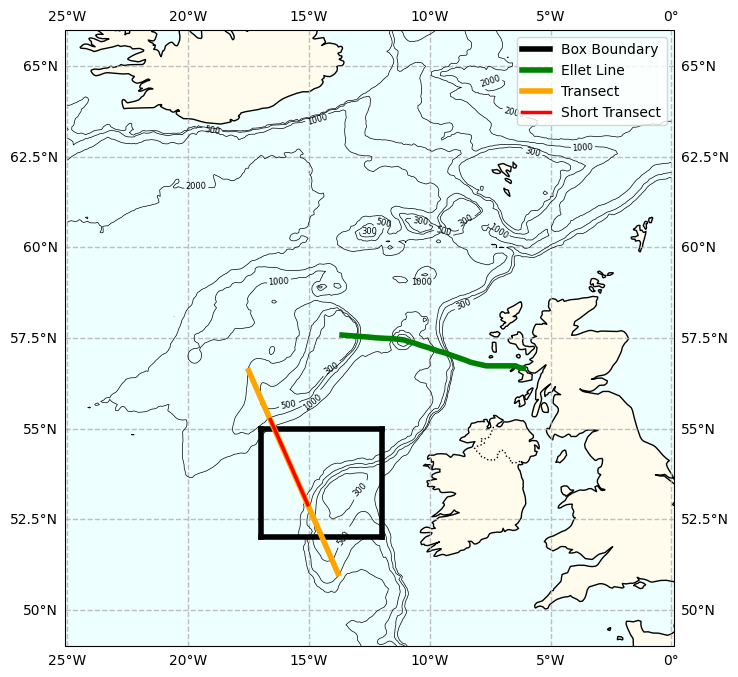

In [18]:

projection = ccrs.PlateCarree()
plt.figure(figsize=(10,8))
ax = plt.axes(projection=projection)
ax.set_extent([-25.1, 0.1, 49, 66], crs=projection)  
ax.set_aspect(1.5)
gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=1, alpha=0.8)

# Plot the data points
contour_levels = [300, 500, 1000, 2000]
deptho = np.array(df_bathy['deptho']).reshape(len(df_bathy['latitude'].unique()), len(df_bathy['longitude'].unique()))
# contour = ax.contour(df_bathy['longitude'].unique(), df_bathy['latitude'].unique(), deptho, cmap='Blues', levels=contour_levels, linewidths=1.1,transform=ccrs.PlateCarree())


# # Generate colors for each level using the updated 'Blues' colormap
# cmap = plt.get_cmap('Blues')
# colors = [cmap(i / (len(contour_levels) - 1)) for i in range(len(contour_levels))]

contour = ax.contour(
    df_bathy['longitude'].unique(), df_bathy['latitude'].unique(), deptho,
    levels=contour_levels, colors='black', linewidths=0.5, transform=ccrs.PlateCarree()
)
ax.clabel(contour, inline=True, fontsize=6, fmt='%d')  # Label contour lines with depth levels



plt.plot([box.lon1, box.lon2], [box.lat1, box.lat1], color='black', linewidth=4, label="Box Boundary")
plt.plot([box.lon1, box.lon2], [box.lat2, box.lat2], color='black', linewidth=4)
plt.plot([box.lon1, box.lon1], [box.lat1, box.lat2], color='black', linewidth=4)
plt.plot([box.lon2, box.lon2], [box.lat1, box.lat2], color='black', linewidth=4)

scatter = plt.plot(stations_df['Longitude'], stations_df['Latitude'], c='green', linewidth=4, transform=ccrs.PlateCarree(), label='Ellet Line')
scatterP = plt.plot(transectP.lons, transectP.lats, c='orange', linewidth=4, transform=ccrs.PlateCarree(), label='Transect')
scatterPS = plt.plot(transectPS.lons, transectPS.lats, c='red', linewidth=2.5, linestyle='-', transform=ccrs.PlateCarree(), label='Short Transect')

# Get handles and labels for plot elements
# handles, labels = ax.get_legend_handles_labels()
# legend_patches = [
#     mpatches.Patch(color=colors[i], label=f'{contour_levels[i]} m')
#     for i in range(len(contour_levels))
# ]
# all_handles = handles + legend_patches
# all_labels = labels + [f'{level} m' for level in contour_levels]

# Customize the plot
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='#FFFCED')
ax.add_feature(cfeature.OCEAN, facecolor='#EDFFFE')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.xaxis.set_major_formatter(LongitudeFormatter())  
ax.yaxis.set_major_formatter(LatitudeFormatter())  

# plt.legend(all_handles, all_labels, title="Legend", loc='upper right')
plt.legend(loc='upper right')
# plt.title('Stations along Porcupine Bank')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### 4. Calculate Flow for all data

Transect no.0
Angle theta = -56.59217541029108
Total distance d = 280174.63304310496 m
Initial coordinates: (52.9, -15.05)
Final coordinates: (55.25, -16.6)
Starting interpolations...
Flux calculated!
Date: 1/1993
total Q = 8.0686 Sv
total A = 112.0699 km2
Starting interpolations...
Flux calculated!
Date: 2/1993
total Q = 2.4647 Sv
total A = 112.0699 km2
Starting interpolations...
Flux calculated!
Date: 3/1993
total Q = 1.9664 Sv
total A = 112.0699 km2
Starting interpolations...
Flux calculated!
Date: 4/1993
total Q = 4.2721 Sv
total A = 112.0699 km2
Starting interpolations...
Flux calculated!
Date: 5/1993
total Q = 0.7559 Sv
total A = 112.0699 km2
Starting interpolations...
Flux calculated!
Date: 6/1993
total Q = 2.1135 Sv
total A = 112.0699 km2
Starting interpolations...
Flux calculated!
Date: 7/1993
total Q = 5.7653 Sv
total A = 112.0699 km2
Starting interpolations...
Flux calculated!
Date: 8/1993
total Q = 5.3231 Sv
total A = 112.0699 km2
Starting interpolations...
Flux calculated!

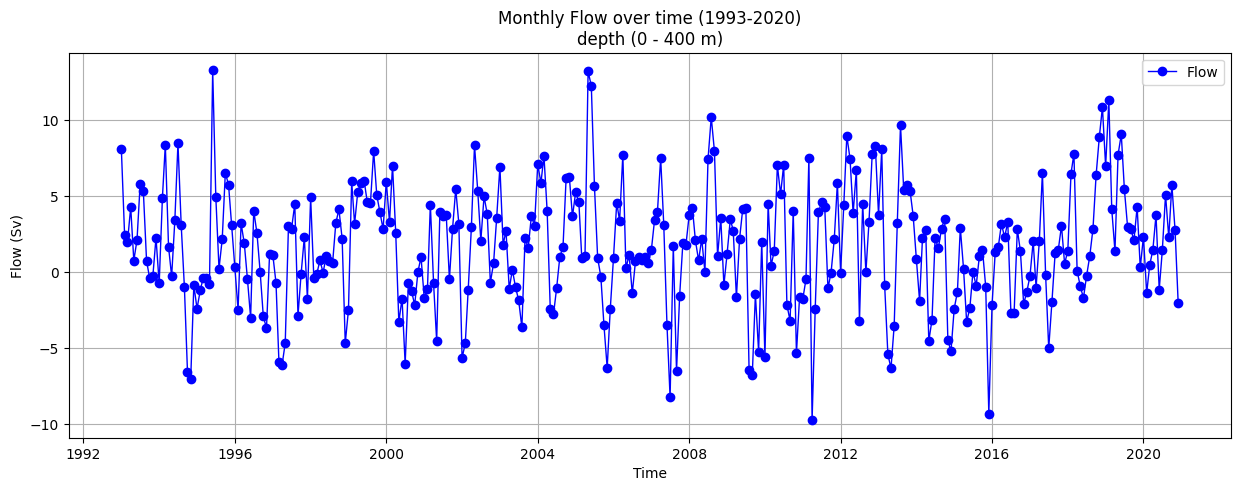

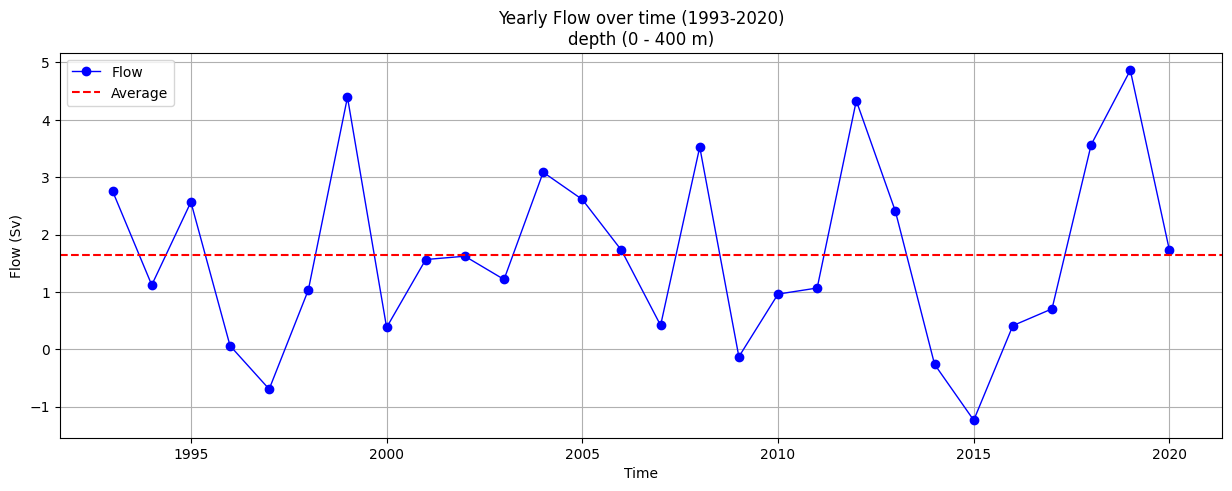

In [19]:
flow_df400 = pd.DataFrame(columns=['Year', 'Month', 'Area', 'Flow'])
years = pd.to_datetime(data.time).year.unique()

params = {
            'delta_distance': 25000, # m
            'delta_depth': 50, # m
            'max_depth': 400, # m
            'min_depth': 0, # m
            'precision': 5 # decimal points
        }
method = 'linear'

transectsInfo = get_transect_grid(stlat1, stlat2, stlon1, stlon2, 0, params)
transectsInfo.print_info()

velocities_per_year = []
# For a specific year
# years = [1993]
for year in years:

    # Selecting data for analysing that year
    data_year = data.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
    months = pd.to_datetime(data.time).month.unique()

    velocities_by_month = []
    # For a specific month
    # months = [1]
    for month in months:

        data_month = data.sel(time=slice(f"{year}-{month}-01", f"{year}-{month}-28"))

        df = data_month.to_dataframe().reset_index()
        variables = ['so', 'thetao', 'uo', 'vo']
        df = df[['depth', 'latitude', 'longitude', 'time', 'so', 'thetao', 'uo', 'vo']].dropna(subset = variables)

        ######
        velocities = generate_transect_values(month, year, df, transectsInfo, method)
        # Calculate flux in the subtransect
        Q = 0.0
        A = 0.0
        Q_transect, A_transect = calculate_flux(transectsInfo.distances, transectsInfo.depths, velocities)
        Q += (Q_transect /1000000)
        A += (A_transect /1000000)
        #####
            
        print(f"Date: {month}/{year}")
        print(f"total Q = {np.round(Q, 4)} Sv")
        print(f"total A = {np.round(A, 4)} km2")
        flow_df400.loc[len(flow_df400)] = [year, month, A, Q]

        velocities_by_month.append(velocities)

    velocities_per_year.append(velocities_by_month)    
    

anual_flow_df400 = pd.DataFrame(columns=['Year', 'Flow'])

flow_df400['date'] = pd.to_datetime(flow_df400[['Year', 'Month']].assign(day=1))
flow_df400['Year'] = flow_df400['date'].dt.year
flow_df400['Month'] = flow_df400['date'].dt.month

for year in flow_df400['Year'].unique():
    Qanual_mean = np.mean(flow_df400[(flow_df400['Year']==year)]['Flow'])

    anual_flow_df400.loc[len(anual_flow_df400)] = [year, Qanual_mean]


# Plot Montly
plt.figure(figsize=(15, 5))
plt.plot(flow_df400['date'], flow_df400['Flow'], marker='o', color='b', linewidth=1, label='Flow')
# plt.axhline(y=0, color='red', linestyle='-', lable)

flow_df400 = flow_df400.drop(columns={'date'})

plt.xlabel('Time')
plt.ylabel('Flow (Sv)')
plt.title('Monthly Flow over time (1993-2020)\ndepth (0 - 400 m)')

plt.grid()
plt.legend()
plt.show()


# Plot Yearly

plt.figure(figsize=(15, 5))
plt.plot(anual_flow_df400['Year'], anual_flow_df400['Flow'], marker='o', color='b', linewidth=1, label='Flow')
plt.axhline(y=np.mean(anual_flow_df400['Flow']), color='red', linestyle='--', label='Average')

plt.xlabel('Time')
plt.ylabel('Flow (Sv)')
plt.title('Yearly Flow over time (1993-2020)\ndepth (0 - 400 m)')

plt.grid()
plt.legend()
plt.show()


Transect no.0
Angle theta = -56.59217541029108
Total distance d = 280174.63304310496 m
Initial coordinates: (52.9, -15.05)
Final coordinates: (55.25, -16.6)
Starting interpolations...
Flux calculated!
Date: 1/1993
total Q = 1.5497 Sv
total A = 28.0175 km2
Starting interpolations...
Flux calculated!
Date: 2/1993
total Q = 0.4545 Sv
total A = 28.0175 km2
Starting interpolations...
Flux calculated!
Date: 3/1993
total Q = 0.228 Sv
total A = 28.0175 km2
Starting interpolations...
Flux calculated!
Date: 4/1993
total Q = 0.8696 Sv
total A = 28.0175 km2
Starting interpolations...
Flux calculated!
Date: 5/1993
total Q = 0.0735 Sv
total A = 28.0175 km2
Starting interpolations...
Flux calculated!
Date: 6/1993
total Q = 0.4272 Sv
total A = 28.0175 km2
Starting interpolations...
Flux calculated!
Date: 7/1993
total Q = 1.4364 Sv
total A = 28.0175 km2
Starting interpolations...
Flux calculated!
Date: 8/1993
total Q = 1.2459 Sv
total A = 28.0175 km2
Starting interpolations...
Flux calculated!
Date: 9/

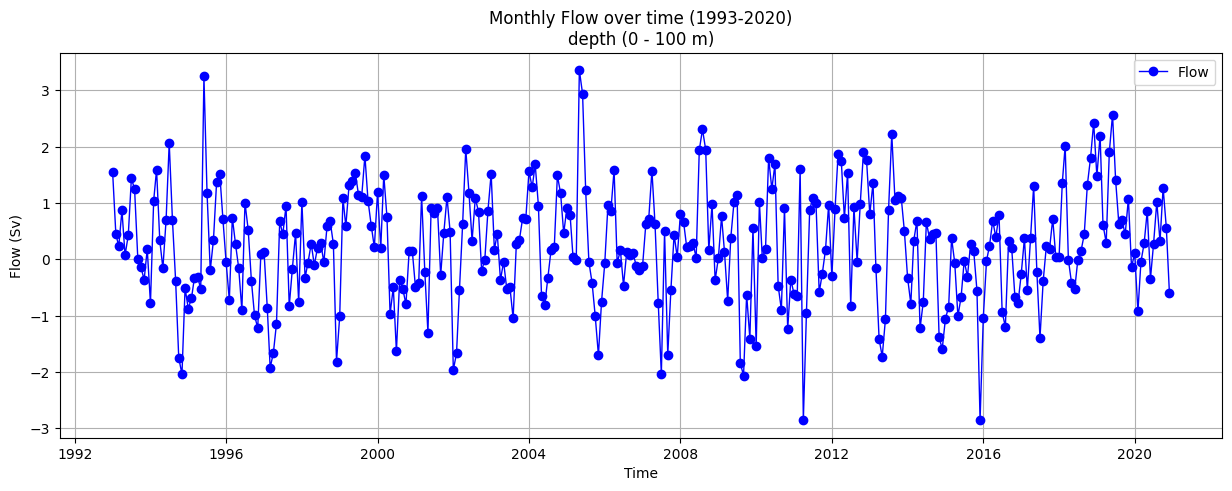

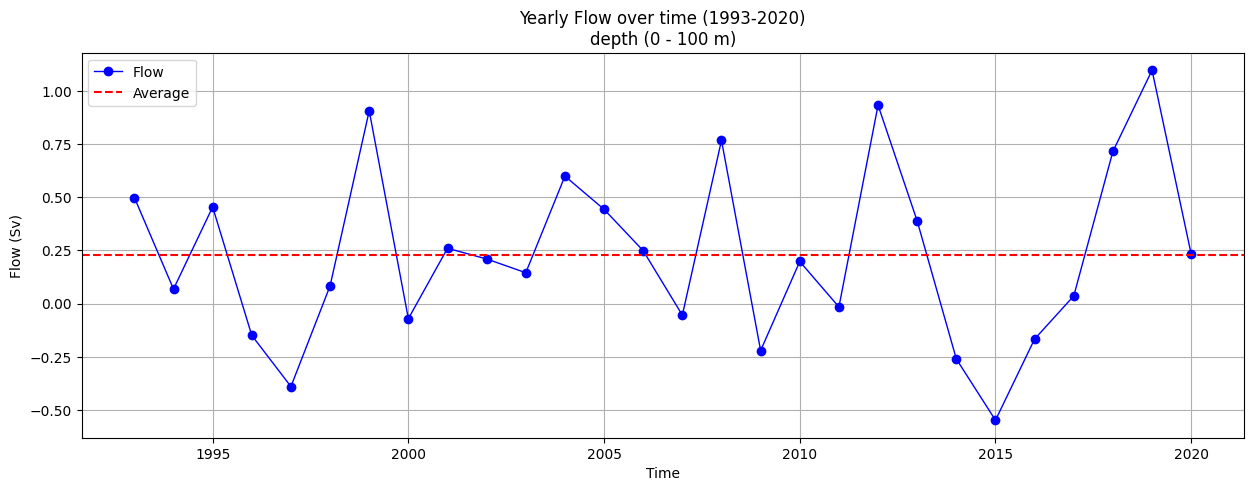

In [20]:
flow_df100 = pd.DataFrame(columns=['Year', 'Month', 'Area', 'Flow'])
years = pd.to_datetime(data.time).year.unique()

params = {
            'delta_distance': 25000, # m
            'delta_depth': 50, # m
            'max_depth': 100, # m
            'min_depth': 0, # m
            'precision': 5 # decimal points
        }
method = 'linear'

transectsInfo = get_transect_grid(stlat1, stlat2, stlon1, stlon2, 0, params)
transectsInfo.print_info()

velocities_per_year = []
# For a specific year
# years = [1993]
for year in years:

    # Selecting data for analysing that year
    data_year = data.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
    months = pd.to_datetime(data.time).month.unique()

    velocities_by_month = []
    # For a specific month
    # months = [1]
    for month in months:

        data_month = data.sel(time=slice(f"{year}-{month}-01", f"{year}-{month}-28"))

        df = data_month.to_dataframe().reset_index()
        variables = ['so', 'thetao', 'uo', 'vo']
        df = df[['depth', 'latitude', 'longitude', 'time', 'so', 'thetao', 'uo', 'vo']].dropna(subset = variables)

        ######
        velocities = generate_transect_values(month, year, df, transectsInfo, method)
        # Calculate flux in the subtransect
        Q = 0.0
        A = 0.0
        Q_transect, A_transect = calculate_flux(transectsInfo.distances, transectsInfo.depths, velocities)
        Q += (Q_transect /1000000)
        A += (A_transect /1000000)
        #####
            
        print(f"Date: {month}/{year}")
        print(f"total Q = {np.round(Q, 4)} Sv")
        print(f"total A = {np.round(A, 4)} km2")
        flow_df100.loc[len(flow_df100)] = [year, month, A, Q]

        velocities_by_month.append(velocities)

    velocities_per_year.append(velocities_by_month)    
    

anual_flow_df100 = pd.DataFrame(columns=['Year', 'Flow'])

flow_df100['date'] = pd.to_datetime(flow_df100[['Year', 'Month']].assign(day=1))
flow_df100['Year'] = flow_df100['date'].dt.year
flow_df100['Month'] = flow_df100['date'].dt.month

for year in flow_df100['Year'].unique():
    Qanual_mean = np.mean(flow_df100[(flow_df100['Year']==year)]['Flow'])

    anual_flow_df100.loc[len(anual_flow_df100)] = [year, Qanual_mean]


# Plot Montly
plt.figure(figsize=(15, 5))
plt.plot(flow_df100['date'], flow_df100['Flow'], marker='o', color='b', linewidth=1, label='Flow')
# plt.axhline(y=0, color='red', linestyle='-', lable)

flow_df100 = flow_df100.drop(columns={'date'})

plt.xlabel('Time')
plt.ylabel('Flow (Sv)')
plt.title('Monthly Flow over time (1993-2020)\ndepth (0 - 100 m)')

plt.grid()
plt.legend()
plt.show()


# Plot Yearly

plt.figure(figsize=(15, 5))
plt.plot(anual_flow_df100['Year'], anual_flow_df100['Flow'], marker='o', color='b', linewidth=1, label='Flow')
plt.axhline(y=np.mean(anual_flow_df100['Flow']), color='red', linestyle='--', label='Average')

plt.xlabel('Time')
plt.ylabel('Flow (Sv)')
plt.title('Yearly Flow over time (1993-2020)\ndepth (0 - 100 m)')

plt.grid()
plt.legend()
plt.show()


Transect no.0
Angle theta = -56.59217541029108
Total distance d = 280174.63304310496 m
Initial coordinates: (52.9, -15.05)
Final coordinates: (55.25, -16.6)
Starting interpolations...
Flux calculated!
Date: 1/1993
total Q = 24.6467 Sv
total A = 409.7653 km2
Starting interpolations...
Flux calculated!
Date: 2/1993
total Q = 5.9258 Sv
total A = 409.7653 km2
Starting interpolations...
Flux calculated!
Date: 3/1993
total Q = 4.1073 Sv
total A = 409.7653 km2
Starting interpolations...
Flux calculated!
Date: 4/1993
total Q = 11.8658 Sv
total A = 409.7653 km2
Starting interpolations...
Flux calculated!
Date: 5/1993
total Q = 3.1761 Sv
total A = 409.7653 km2
Starting interpolations...
Flux calculated!
Date: 6/1993
total Q = 2.8452 Sv
total A = 409.7653 km2
Starting interpolations...
Flux calculated!
Date: 7/1993
total Q = 12.2078 Sv
total A = 409.7653 km2
Starting interpolations...
Flux calculated!
Date: 8/1993
total Q = 13.9785 Sv
total A = 409.7653 km2
Starting interpolations...
Flux calcula

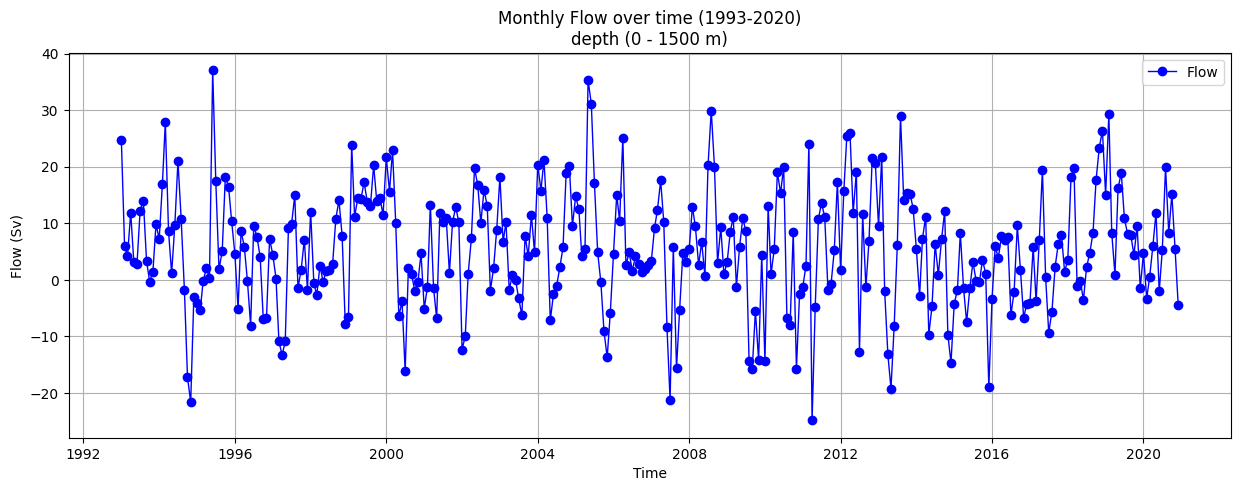

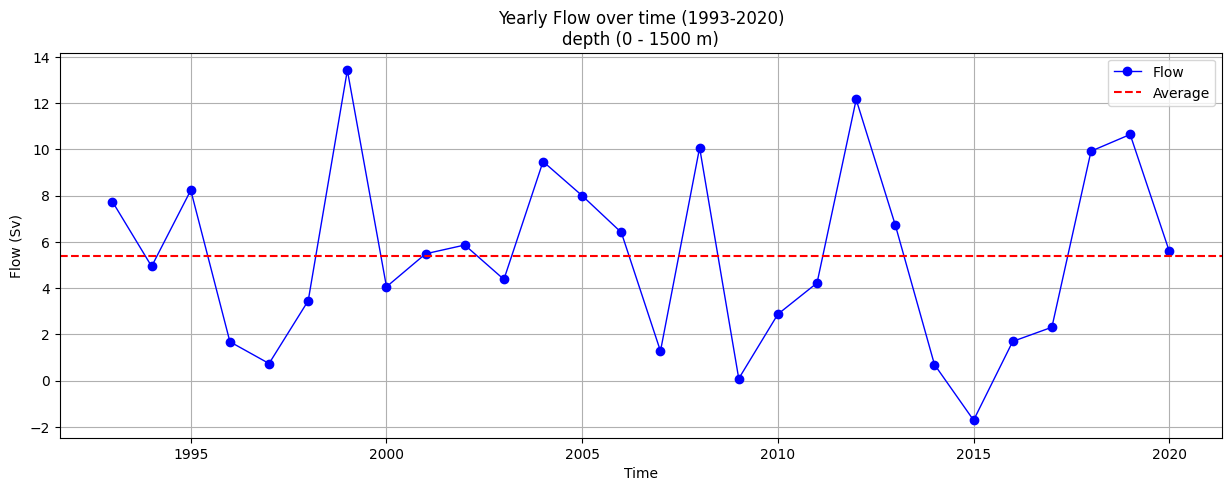

In [21]:
flow_df1500 = pd.DataFrame(columns=['Year', 'Month', 'Area', 'Flow'])
years = pd.to_datetime(data.time).year.unique()

params = {
            'delta_distance': 25000, # m
            'delta_depth': 50, # m
            'max_depth': 1500, # m
            'min_depth': 0, # m
            'precision': 5 # decimal points
        }
method = 'linear'

transectsInfo = get_transect_grid(stlat1, stlat2, stlon1, stlon2, 0, params)
transectsInfo.print_info()

velocities_per_year = []
# For a specific year
# years = [1993]
for year in years:

    # Selecting data for analysing that year
    data_year = data.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
    months = pd.to_datetime(data.time).month.unique()

    velocities_by_month = []
    # For a specific month
    # months = [1]
    for month in months:

        data_month = data.sel(time=slice(f"{year}-{month}-01", f"{year}-{month}-28"))

        df = data_month.to_dataframe().reset_index()
        variables = ['so', 'thetao', 'uo', 'vo']
        df = df[['depth', 'latitude', 'longitude', 'time', 'so', 'thetao', 'uo', 'vo']].dropna(subset = variables)

        ######
        velocities = generate_transect_values(month, year, df, transectsInfo, method)
        # Calculate flux in the subtransect
        Q = 0.0
        A = 0.0
        Q_transect, A_transect = calculate_flux(transectsInfo.distances, transectsInfo.depths, velocities)
        Q += (Q_transect /1000000)
        A += (A_transect /1000000)
        #####
            
        print(f"Date: {month}/{year}")
        print(f"total Q = {np.round(Q, 4)} Sv")
        print(f"total A = {np.round(A, 4)} km2")
        flow_df1500.loc[len(flow_df1500)] = [year, month, A, Q]

        velocities_by_month.append(velocities)

    velocities_per_year.append(velocities_by_month)    
    

anual_flow_df1500 = pd.DataFrame(columns=['Year', 'Flow'])

flow_df1500['date'] = pd.to_datetime(flow_df1500[['Year', 'Month']].assign(day=1))
flow_df1500['Year'] = flow_df1500['date'].dt.year
flow_df1500['Month'] = flow_df1500['date'].dt.month

for year in flow_df1500['Year'].unique():
    Qanual_mean = np.mean(flow_df1500[(flow_df1500['Year']==year)]['Flow'])

    anual_flow_df1500.loc[len(anual_flow_df1500)] = [year, Qanual_mean]


# Plot Montly
plt.figure(figsize=(15, 5))
plt.plot(flow_df1500['date'], flow_df1500['Flow'], marker='o', color='b', linewidth=1, label='Flow')
# plt.axhline(y=0, color='red', linestyle='-', lable)

flow_df1500 = flow_df1500.drop(columns={'date'})

plt.xlabel('Time')
plt.ylabel('Flow (Sv)')
plt.title('Monthly Flow over time (1993-2020)\ndepth (0 - 1500 m)')

plt.grid()
plt.legend()
plt.show()


# Plot Yearly

plt.figure(figsize=(15, 5))
plt.plot(anual_flow_df1500['Year'], anual_flow_df1500['Flow'], marker='o', color='b', linewidth=1, label='Flow')
plt.axhline(y=np.mean(anual_flow_df1500['Flow']), color='red', linestyle='--', label='Average')

plt.xlabel('Time')
plt.ylabel('Flow (Sv)')
plt.title('Yearly Flow over time (1993-2020)\ndepth (0 - 1500 m)')

plt.grid()
plt.legend()
plt.show()


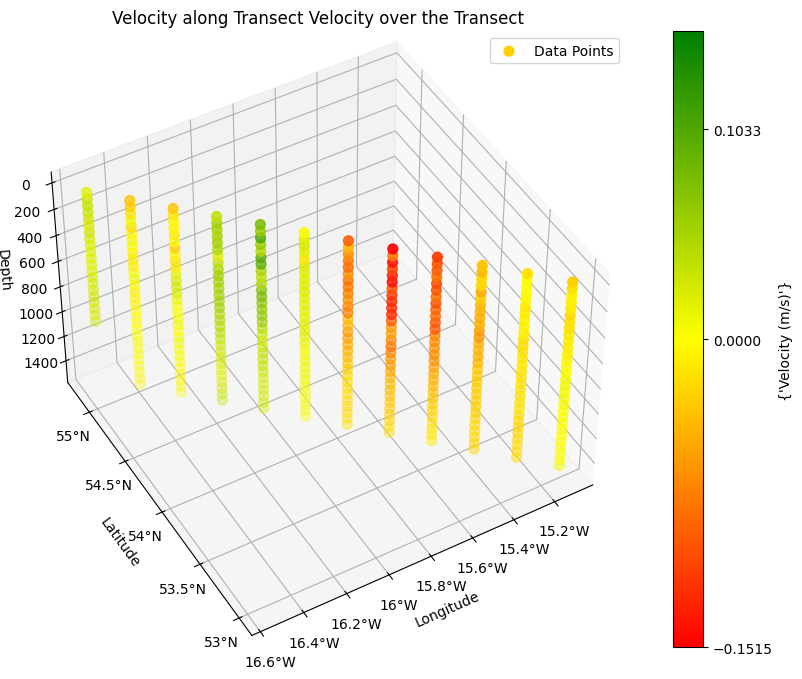

In [23]:
plot_variable_in_3D('magnitude', velocities, transectsInfo, 'velocity')

In [ ]:
anualflow_df = pd.DataFrame(columns=['Year', 'Flow'])

flow_df['date'] = pd.to_datetime(flow_df[['Year', 'Month']].assign(day=1))
flow_df['Year'] = flow_df['date'].dt.year
flow_df['Month'] = flow_df['date'].dt.month

for year in flow_df['Year'].unique():
    Qanual_mean = np.mean(flow_df[(flow_df['Year']==year)]['Flow'])

    anualflow_df.loc[len(anualflow_df)] = [year, Qanual_mean]


anualflow_df


,Year,Flow
0,1993.0,4.230355
1,1994.0,4.926458
2,1995.0,5.035103
3,1996.0,3.531063
4,1997.0,3.057153
5,1998.0,2.689265
6,1999.0,2.901722
7,2000.0,3.885466
8,2001.0,2.868256
9,2002.0,3.825630


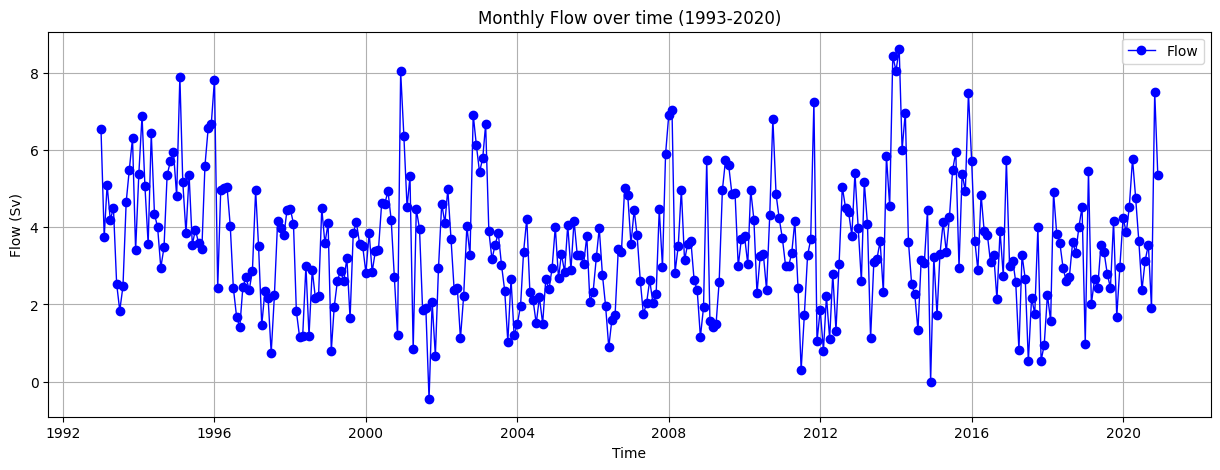

In [ ]:
# Plot
plt.figure(figsize=(15, 5))
plt.plot(flow_df['date'], flow_df['Flow'], marker='o', color='b', linewidth=1, label='Flow')
# plt.axhline(y=0, color='red', linestyle='-', lable)

flow_df = flow_df.drop(columns={'date'})
# Labels and title
plt.xlabel('Time')
plt.ylabel('Flow (Sv)')
plt.title('Monthly Flow over time (1993-2020)')

# Ensure all x-tick labels are displayed
# plt.xticks(flow_df['date'])  # Display all tick labels for x-axis
plt.grid()
# Legend
plt.legend()

# Show plot
plt.show()


In [ ]:
flow_df

,Year,Month,Area,Flow
0,1993,1,135.457284,6.148326
1,1993,2,135.457284,3.587732
2,1993,3,135.457284,5.079080
3,1993,4,135.457284,3.929222
4,1993,5,135.457284,4.467854
...,...,...,...,...
331,2020,8,135.457284,3.175617
332,2020,9,135.457284,3.398729
333,2020,10,135.457284,1.721884
334,2020,11,135.457284,7.195191


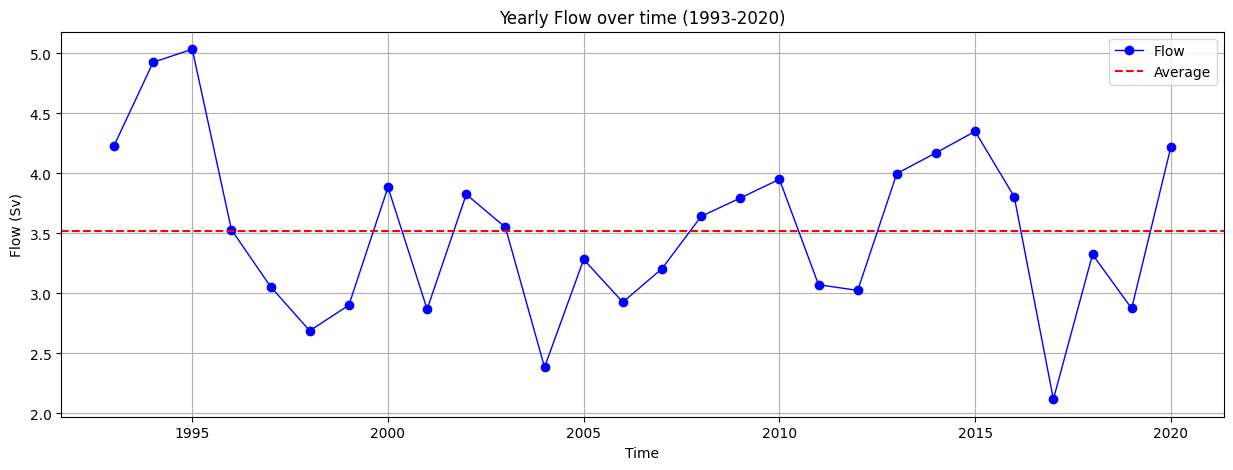

In [ ]:
# Plot
plt.figure(figsize=(15, 5))
plt.plot(anualflow_df['Year'], anualflow_df['Flow'], marker='o', color='b', linewidth=1, label='Flow')
plt.axhline(y=np.mean(anualflow_df['Flow']), color='red', linestyle='--', label='Average')


# Labels and title
plt.xlabel('Time')
plt.ylabel('Flow (Sv)')
plt.title('Yearly Flow over time (1993-2020)')

# Ensure all x-tick labels are displayed
# plt.xticks(flow_df['date'])  # Display all tick labels for x-axis
plt.grid()
# Legend
plt.legend()

# Show plot
plt.show()


### Save to Excel file

In [24]:
file_path = 'data/Transport_1993_2020.xlsx'

# Check if the file exists
if os.path.exists(file_path):
    with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        flow_df100.to_excel(writer, sheet_name='Short Line 100 m (M)', index=False)
        anual_flow_df100.to_excel(writer, sheet_name='Short Line 100 m (Y)', index=False)
        flow_df400.to_excel(writer, sheet_name='Short Line 400 m (M)', index=False)
        anual_flow_df400.to_excel(writer, sheet_name='Short Line 400 m (Y)', index=False)
        flow_df1500.to_excel(writer, sheet_name='Short Line 1500 m (M)', index=False)
        anual_flow_df1500.to_excel(writer, sheet_name='Short Line 1500 m (Y)', index=False)
else:
    with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
        flow_df100.to_excel(writer, sheet_name='Short Line 100 m (M)', index=False)
        anual_flow_df100.to_excel(writer, sheet_name='Short Line 100 m (Y)', index=False)
        flow_df400.to_excel(writer, sheet_name='Short Line 400 m (M)', index=False)
        anual_flow_df400.to_excel(writer, sheet_name='Short Line 400 m (Y)', index=False)
        flow_df1500.to_excel(writer, sheet_name='Short Line 1500 m (M)', index=False)
        anual_flow_df1500.to_excel(writer, sheet_name='Short Line 1500 m (Y)', index=False)

### Same for Ellet Line Again

Transect no.0
Angle theta = -6.963238689714188
Total distance d = 463737.60615645355 m
Initial coordinates: (56.667, -6.133)
Final coordinates: (57.583, -13.633)
Starting interpolations...
Flux calculated!
Date: 1/1993
total Q = 8.7958 Sv
total A = 178.1499 km2
Starting interpolations...
Flux calculated!
Date: 2/1993
total Q = 4.9497 Sv
total A = 178.1499 km2
Starting interpolations...
Flux calculated!
Date: 3/1993
total Q = 6.9 Sv
total A = 178.1499 km2
Starting interpolations...
Flux calculated!
Date: 4/1993
total Q = 5.2303 Sv
total A = 178.1499 km2
Starting interpolations...
Flux calculated!
Date: 5/1993
total Q = 5.7516 Sv
total A = 178.1499 km2
Starting interpolations...
Flux calculated!
Date: 6/1993
total Q = 3.1523 Sv
total A = 178.1499 km2
Starting interpolations...
Flux calculated!
Date: 7/1993
total Q = 2.2472 Sv
total A = 178.1499 km2
Starting interpolations...
Flux calculated!
Date: 8/1993
total Q = 3.0552 Sv
total A = 178.1499 km2
Starting interpolations...
Flux calculate

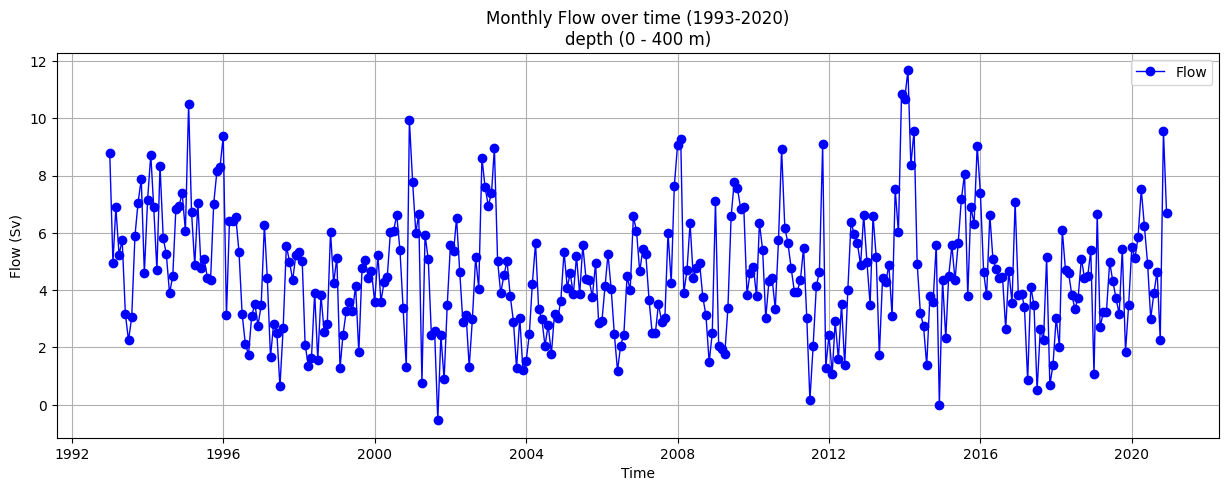

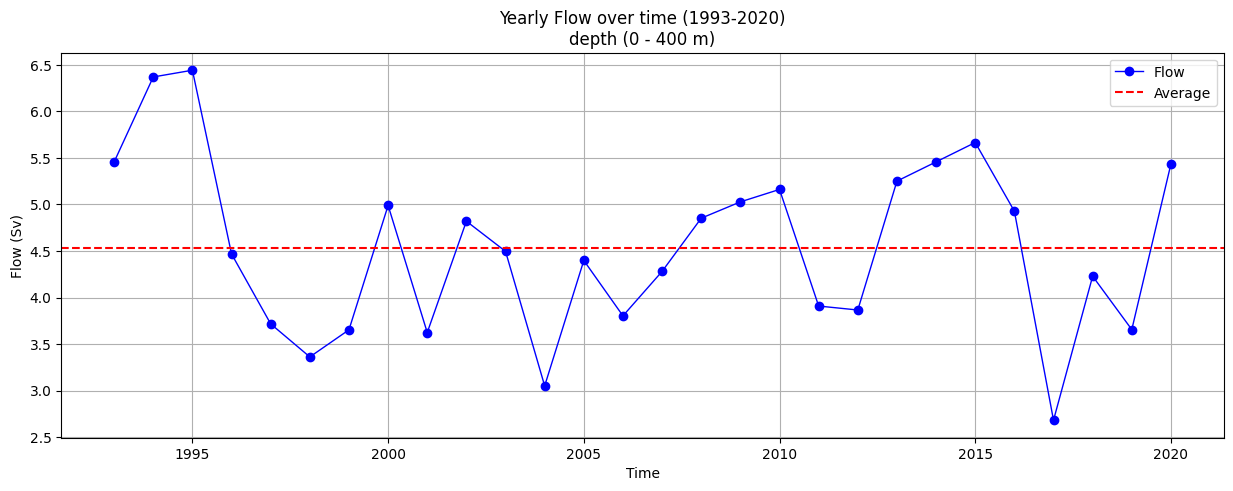

In [30]:
flow_df400_el = pd.DataFrame(columns=['Year', 'Month', 'Area', 'Flow'])
years = pd.to_datetime(data.time).year.unique()

params = {
            'delta_distance': 25000, # m
            'delta_depth': 50, # m
            'max_depth': 400, # m
            'min_depth': 0, # m
            'precision': 5 # decimal points
        }
method = 'linear'

transectsInfo = get_transect_grid(stations_df['Latitude'][0], stations_df['Latitude'][len(stations_df)-1], stations_df['Longitude'][0], stations_df['Longitude'][len(stations_df)-1], 0, params)
transectsInfo.print_info()

velocities_per_year = []
# For a specific year
# years = [1993]
for year in years:

    # Selecting data for analysing that year
    data_year = data.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
    months = pd.to_datetime(data.time).month.unique()

    velocities_by_month = []
    # For a specific month
    # months = [1]
    for month in months:

        data_month = data.sel(time=slice(f"{year}-{month}-01", f"{year}-{month}-28"))

        df = data_month.to_dataframe().reset_index()
        variables = ['so', 'thetao', 'uo', 'vo']
        df = df[['depth', 'latitude', 'longitude', 'time', 'so', 'thetao', 'uo', 'vo']].dropna(subset = variables)

        ######
        velocities = generate_transect_values(month, year, df, transectsInfo, method)
        # Calculate flux in the subtransect
        Q = 0.0
        A = 0.0
        Q_transect, A_transect = calculate_flux(transectsInfo.distances, transectsInfo.depths, velocities)
        Q += (Q_transect /1000000)
        A += (A_transect /1000000)
        #####
            
        print(f"Date: {month}/{year}")
        print(f"total Q = {np.round(Q, 4)} Sv")
        print(f"total A = {np.round(A, 4)} km2")
        flow_df400_el.loc[len(flow_df400_el)] = [year, month, A, Q]

        velocities_by_month.append(velocities)

    velocities_per_year.append(velocities_by_month)    
    

anual_flow_df400_el = pd.DataFrame(columns=['Year', 'Flow'])

flow_df400_el['date'] = pd.to_datetime(flow_df400_el[['Year', 'Month']].assign(day=1))
flow_df400_el['Year'] = flow_df400_el['date'].dt.year
flow_df400_el['Month'] = flow_df400_el['date'].dt.month

for year in flow_df400_el['Year'].unique():
    Qanual_mean = np.mean(flow_df400_el[(flow_df400_el['Year']==year)]['Flow'])

    anual_flow_df400_el.loc[len(anual_flow_df400_el)] = [year, Qanual_mean]


# Plot Montly
plt.figure(figsize=(15, 5))
plt.plot(flow_df400_el['date'], flow_df400_el['Flow'], marker='o', color='b', linewidth=1, label='Flow')
# plt.axhline(y=0, color='red', linestyle='-', lable)

flow_df400_el = flow_df400_el.drop(columns={'date'})

plt.xlabel('Time')
plt.ylabel('Flow (Sv)')
plt.title('Monthly Flow over time (1993-2020)\ndepth (0 - 400 m)')

plt.grid()
plt.legend()
plt.show()


# Plot Yearly

plt.figure(figsize=(15, 5))
plt.plot(anual_flow_df400_el['Year'], anual_flow_df400_el['Flow'], marker='o', color='b', linewidth=1, label='Flow')
plt.axhline(y=np.mean(anual_flow_df400_el['Flow']), color='red', linestyle='--', label='Average')

plt.xlabel('Time')
plt.ylabel('Flow (Sv)')
plt.title('Yearly Flow over time (1993-2020)\ndepth (0 - 400 m)')

plt.grid()
plt.legend()
plt.show()


Transect no.0
Angle theta = -6.963238689714188
Total distance d = 463737.60615645355 m
Initial coordinates: (56.667, -6.133)
Final coordinates: (57.583, -13.633)
Starting interpolations...
Flux calculated!
Date: 1/1993
total Q = 1.7618 Sv
total A = 46.3738 km2
Starting interpolations...
Flux calculated!
Date: 2/1993
total Q = 1.0259 Sv
total A = 46.3738 km2
Starting interpolations...
Flux calculated!
Date: 3/1993
total Q = 1.43 Sv
total A = 46.3738 km2
Starting interpolations...
Flux calculated!
Date: 4/1993
total Q = 1.5281 Sv
total A = 46.3738 km2
Starting interpolations...
Flux calculated!
Date: 5/1993
total Q = 1.5413 Sv
total A = 46.3738 km2
Starting interpolations...
Flux calculated!
Date: 6/1993
total Q = 0.8636 Sv
total A = 46.3738 km2
Starting interpolations...
Flux calculated!
Date: 7/1993
total Q = 0.4005 Sv
total A = 46.3738 km2
Starting interpolations...
Flux calculated!
Date: 8/1993
total Q = 0.5385 Sv
total A = 46.3738 km2
Starting interpolations...
Flux calculated!
Date

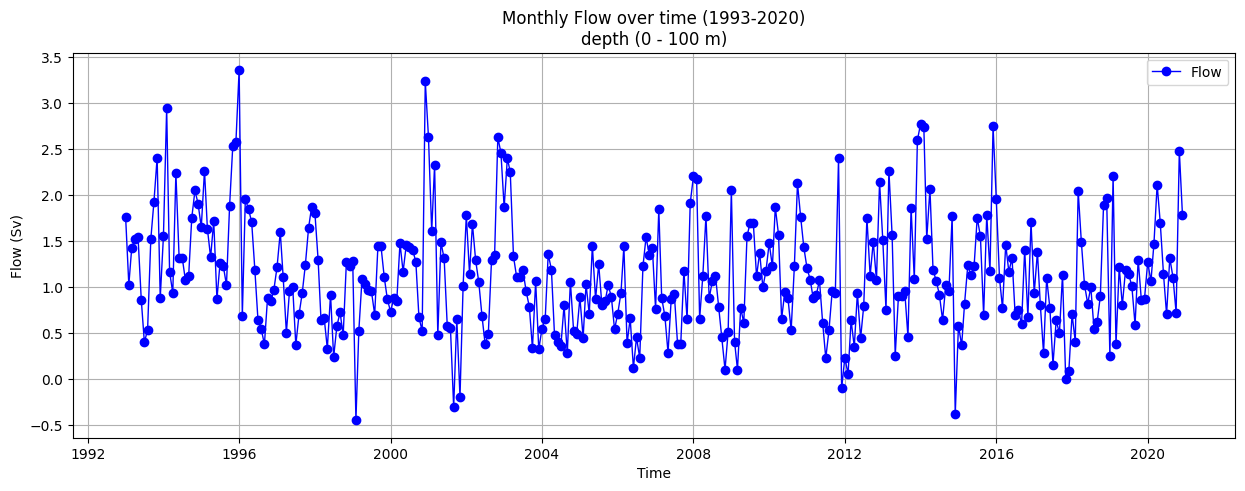

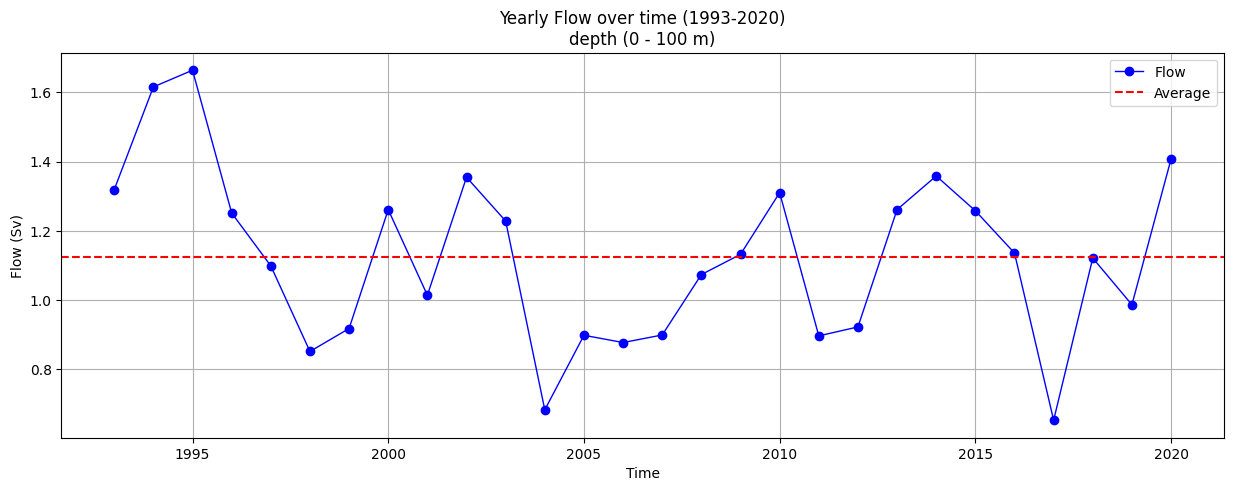

In [29]:
flow_df100_el = pd.DataFrame(columns=['Year', 'Month', 'Area', 'Flow'])
years = pd.to_datetime(data.time).year.unique()

params = {
            'delta_distance': 25000, # m
            'delta_depth': 50, # m
            'max_depth': 100, # m
            'min_depth': 0, # m
            'precision': 5 # decimal points
        }
method = 'linear'

transectsInfo = get_transect_grid(stations_df['Latitude'][0], stations_df['Latitude'][len(stations_df)-1], stations_df['Longitude'][0], stations_df['Longitude'][len(stations_df)-1], 0, params)
transectsInfo.print_info()

velocities_per_year = []
# For a specific year
# years = [1993]
for year in years:

    # Selecting data for analysing that year
    data_year = data.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
    months = pd.to_datetime(data.time).month.unique()

    velocities_by_month = []
    # For a specific month
    # months = [1]
    for month in months:

        data_month = data.sel(time=slice(f"{year}-{month}-01", f"{year}-{month}-28"))

        df = data_month.to_dataframe().reset_index()
        variables = ['so', 'thetao', 'uo', 'vo']
        df = df[['depth', 'latitude', 'longitude', 'time', 'so', 'thetao', 'uo', 'vo']].dropna(subset = variables)

        ######
        velocities = generate_transect_values(month, year, df, transectsInfo, method)
        # Calculate flux in the subtransect
        Q = 0.0
        A = 0.0
        Q_transect, A_transect = calculate_flux(transectsInfo.distances, transectsInfo.depths, velocities)
        Q += (Q_transect /1000000)
        A += (A_transect /1000000)
        #####
            
        print(f"Date: {month}/{year}")
        print(f"total Q = {np.round(Q, 4)} Sv")
        print(f"total A = {np.round(A, 4)} km2")
        flow_df100_el.loc[len(flow_df100_el)] = [year, month, A, Q]

        velocities_by_month.append(velocities)

    velocities_per_year.append(velocities_by_month)    
    

anual_flow_df100_el = pd.DataFrame(columns=['Year', 'Flow'])

flow_df100_el['date'] = pd.to_datetime(flow_df100_el[['Year', 'Month']].assign(day=1))
flow_df100_el['Year'] = flow_df100_el['date'].dt.year
flow_df100_el['Month'] = flow_df100_el['date'].dt.month

for year in flow_df100_el['Year'].unique():
    Qanual_mean = np.mean(flow_df100_el[(flow_df100_el['Year']==year)]['Flow'])

    anual_flow_df100_el.loc[len(anual_flow_df100_el)] = [year, Qanual_mean]


# Plot Montly
plt.figure(figsize=(15, 5))
plt.plot(flow_df100_el['date'], flow_df100_el['Flow'], marker='o', color='b', linewidth=1, label='Flow')
# plt.axhline(y=0, color='red', linestyle='-', lable)

flow_df100_el = flow_df100_el.drop(columns={'date'})

plt.xlabel('Time')
plt.ylabel('Flow (Sv)')
plt.title('Monthly Flow over time (1993-2020)\ndepth (0 - 100 m)')

plt.grid()
plt.legend()
plt.show()


# Plot Yearly

plt.figure(figsize=(15, 5))
plt.plot(anual_flow_df100_el['Year'], anual_flow_df100_el['Flow'], marker='o', color='b', linewidth=1, label='Flow')
plt.axhline(y=np.mean(anual_flow_df100_el['Flow']), color='red', linestyle='--', label='Average')

plt.xlabel('Time')
plt.ylabel('Flow (Sv)')
plt.title('Yearly Flow over time (1993-2020)\ndepth (0 - 100 m)')

plt.grid()
plt.legend()
plt.show()


Transect no.0
Angle theta = -6.963238689714188
Total distance d = 463737.60615645355 m
Initial coordinates: (56.667, -6.133)
Final coordinates: (57.583, -13.633)
Starting interpolations...
Flux calculated!
Date: 1/1993
total Q = 17.7684 Sv
total A = 529.5768 km2
Starting interpolations...
Flux calculated!
Date: 2/1993
total Q = 8.0266 Sv
total A = 529.5768 km2
Starting interpolations...
Flux calculated!
Date: 3/1993
total Q = 12.6803 Sv
total A = 529.5768 km2
Starting interpolations...
Flux calculated!
Date: 4/1993
total Q = 7.5922 Sv
total A = 529.5768 km2
Starting interpolations...
Flux calculated!
Date: 5/1993
total Q = 10.3859 Sv
total A = 529.5768 km2
Starting interpolations...
Flux calculated!
Date: 6/1993
total Q = 3.0376 Sv
total A = 529.5768 km2
Starting interpolations...
Flux calculated!
Date: 7/1993
total Q = 0.4429 Sv
total A = 529.5768 km2
Starting interpolations...
Flux calculated!
Date: 8/1993
total Q = 1.9742 Sv
total A = 529.5768 km2
Starting interpolations...
Flux cal

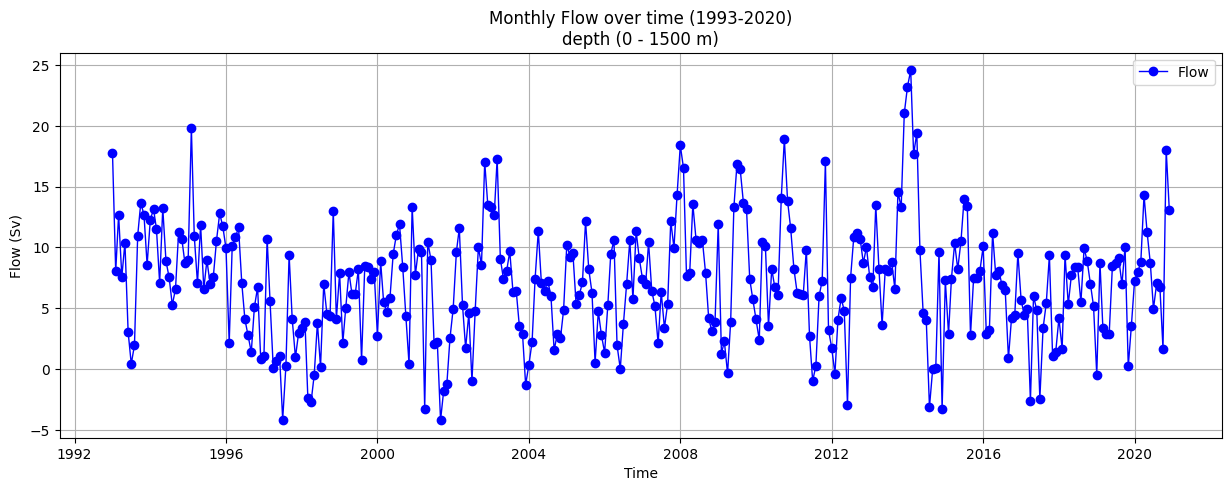

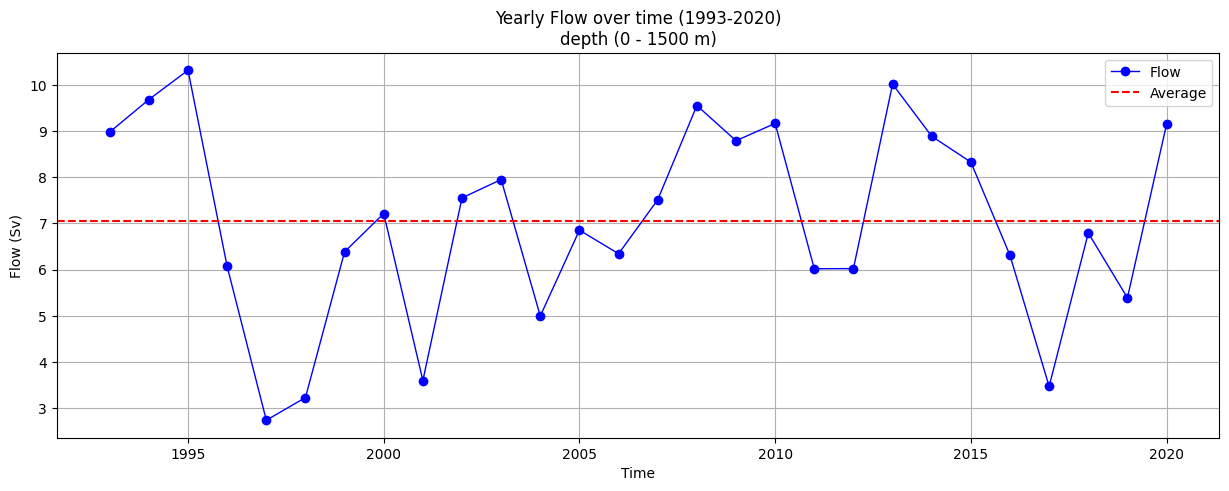

In [28]:
flow_df1500_el = pd.DataFrame(columns=['Year', 'Month', 'Area', 'Flow'])
years = pd.to_datetime(data.time).year.unique()

params = {
            'delta_distance': 25000, # m
            'delta_depth': 50, # m
            'max_depth': 1500, # m
            'min_depth': 0, # m
            'precision': 5 # decimal points
        }
method = 'linear'

transectsInfo = get_transect_grid(stations_df['Latitude'][0], stations_df['Latitude'][len(stations_df)-1], stations_df['Longitude'][0], stations_df['Longitude'][len(stations_df)-1], 0, params)
transectsInfo.print_info()

velocities_per_year = []
# For a specific year
# years = [1993]
for year in years:

    # Selecting data for analysing that year
    data_year = data.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
    months = pd.to_datetime(data.time).month.unique()

    velocities_by_month = []
    # For a specific month
    # months = [1]
    for month in months:

        data_month = data.sel(time=slice(f"{year}-{month}-01", f"{year}-{month}-28"))

        df = data_month.to_dataframe().reset_index()
        variables = ['so', 'thetao', 'uo', 'vo']
        df = df[['depth', 'latitude', 'longitude', 'time', 'so', 'thetao', 'uo', 'vo']].dropna(subset = variables)

        ######
        velocities = generate_transect_values(month, year, df, transectsInfo, method)
        # Calculate flux in the subtransect
        Q = 0.0
        A = 0.0
        Q_transect, A_transect = calculate_flux(transectsInfo.distances, transectsInfo.depths, velocities)
        Q += (Q_transect /1000000)
        A += (A_transect /1000000)
        #####
            
        print(f"Date: {month}/{year}")
        print(f"total Q = {np.round(Q, 4)} Sv")
        print(f"total A = {np.round(A, 4)} km2")
        flow_df1500_el.loc[len(flow_df1500_el)] = [year, month, A, Q]

        velocities_by_month.append(velocities)

    velocities_per_year.append(velocities_by_month)    
    

anual_flow_df1500_el = pd.DataFrame(columns=['Year', 'Flow'])

flow_df1500_el['date'] = pd.to_datetime(flow_df1500_el[['Year', 'Month']].assign(day=1))
flow_df1500_el['Year'] = flow_df1500_el['date'].dt.year
flow_df1500_el['Month'] = flow_df1500_el['date'].dt.month

for year in flow_df1500_el['Year'].unique():
    Qanual_mean = np.mean(flow_df1500_el[(flow_df1500_el['Year']==year)]['Flow'])

    anual_flow_df1500_el.loc[len(anual_flow_df1500_el)] = [year, Qanual_mean]


# Plot Montly
plt.figure(figsize=(15, 5))
plt.plot(flow_df1500_el['date'], flow_df1500_el['Flow'], marker='o', color='b', linewidth=1, label='Flow')
# plt.axhline(y=0, color='red', linestyle='-', lable)

flow_df1500_el = flow_df1500_el.drop(columns={'date'})

plt.xlabel('Time')
plt.ylabel('Flow (Sv)')
plt.title('Monthly Flow over time (1993-2020)\ndepth (0 - 1500 m)')

plt.grid()
plt.legend()
plt.show()


# Plot Yearly

plt.figure(figsize=(15, 5))
plt.plot(anual_flow_df1500_el['Year'], anual_flow_df1500_el['Flow'], marker='o', color='b', linewidth=1, label='Flow')
plt.axhline(y=np.mean(anual_flow_df1500_el['Flow']), color='red', linestyle='--', label='Average')

plt.xlabel('Time')
plt.ylabel('Flow (Sv)')
plt.title('Yearly Flow over time (1993-2020)\ndepth (0 - 1500 m)')

plt.grid()
plt.legend()
plt.show()


In [31]:
file_path = 'data/Transport_1993_2020.xlsx'

# Check if the file exists
if os.path.exists(file_path):
    with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        flow_df100_el.to_excel(writer, sheet_name='Ellet Line 100 m (M)', index=False)
        anual_flow_df100_el.to_excel(writer, sheet_name='Ellet Line 100 m (Y)', index=False)
        flow_df400_el.to_excel(writer, sheet_name='Ellet Line 400 m (M)', index=False)
        anual_flow_df400_el.to_excel(writer, sheet_name='Ellet Line 400 m (Y)', index=False)
        flow_df1500_el.to_excel(writer, sheet_name='Ellet Line 1500 m (M)', index=False)
        anual_flow_df1500_el.to_excel(writer, sheet_name='Ellet Line 1500 m (Y)', index=False)
else:
    with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
        flow_df100_el.to_excel(writer, sheet_name='Ellet Line 100 m (M)', index=False)
        anual_flow_df100_el.to_excel(writer, sheet_name='Ellet Line 100 m (Y)', index=False)
        flow_df400_el.to_excel(writer, sheet_name='Ellet Line 400 m (M)', index=False)
        anual_flow_df400_el.to_excel(writer, sheet_name='Ellet Line 400 m (Y)', index=False)
        flow_df1500_el.to_excel(writer, sheet_name='Ellet Line 1500 m (M)', index=False)
        anual_flow_df1500_el.to_excel(writer, sheet_name='Ellet Line 1500 m (Y)', index=False)